## Strux: Pairwise Preference in Large Language Model Evaluators
### arXiv:2403.16950 [cs.CL]
Notebook Author: Mikhail Ocampo

Research Paper: https://arxiv.org/pdf/2403.16950

<img src="image.png" alt="Pairwise Preference">

Pairwise preference is a powerful technique for evaluating LLM outputs by comparing responses in head-to-head matchups rather than relying on unreliable direct scoring. It is crucial for engineers assessing LLM performance because LLMs are better at ranking two outputs than assigning consistent numerical scores, reducing bias and improving alignment with human judgment. The method works by iteratively comparing pairs, estimating preference probabilities, and leveraging transitivity to construct a global ranking using efficient sorting (e.g., merge-sort with uncertainty-guided beam search). This approach ensures a scalable, interpretable, and statistically grounded evaluation framework for comparing prompts, models, or system outputs.

Strux makes it easy to use pairwise preference to evaluate LLM performance.

## Direct Scoring vs. Pairwise Preference Scoring  

### Direct Scoring  
In **direct scoring**, each response is evaluated **individually** using a predefined scale (e.g., 1-10 rating for coherence). The model assigns an absolute score to each response, but this method can suffer from **inconsistencies across different prompts** and **bias in score calibration**—leading to poor alignment with human judgment.

### Pairwise Preference Scoring  
**Pairwise preference scoring** instead **compares responses in pairs** to determine which is better. This method ensures **better transitivity** and **consistency in ranking** by iteratively applying comparisons across responses. Unlike direct scoring, it avoids **score drift** and **scale mismatches**, leading to **more reliable** rankings, especially in LLM evaluations.  

By leveraging uncertainty-aware comparisons, pairwise scoring provides a **more structured** and **robust** evaluation framework, ensuring global coherence in rankings.

In [1]:
import os
import pandas as pd
from strux.evaluation import PairwisePreferenceRanker, LLMEvaluator

# Load data from JSON file
df = pd.read_json("chatbot_arena_conversations.json", lines=True)


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question_id        33000 non-null  object 
 1   model_a            33000 non-null  object 
 2   model_b            33000 non-null  object 
 3   winner             33000 non-null  object 
 4   judge              33000 non-null  object 
 5   conversation_a     33000 non-null  object 
 6   conversation_b     33000 non-null  object 
 7   turn               33000 non-null  int64  
 8   anony              33000 non-null  bool   
 9   language           33000 non-null  object 
 10  tstamp             33000 non-null  float64
 11  openai_moderation  33000 non-null  object 
 12  toxic_chat_tag     33000 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 3.1+ MB


In [4]:
import json
from typing import List, Dict

def extract_first_user_message(conversation: List[Dict]) -> str:
    try:
        # Get the first user message
        return conversation[0].get('content', '')
    except Exception as e:
        print(f"Error parsing conversation: {e}")
        return ''

# Extract unique prompts from conversation_a (could use either a or b)
unique_prompts = df['conversation_a'].apply(extract_first_user_message).unique()

# Print number of unique prompts and first few examples
print(f"Number of unique prompts: {len(unique_prompts)}")
print("\nExample prompts:")
for prompt in unique_prompts[:5]:
    print(f"\n{prompt}")

Number of unique prompts: 26968

Example prompts:

What is the difference between OpenCL and CUDA?

Why did my parent not invite me to their wedding?

Fuji vs. Nikon, which is better?

How to build an arena for chatbots?

When is it today?


In [5]:
def extract_first_assistant_message(conversation: List[Dict]) -> str:
    try:
        # Get the first assistant message
        return conversation[1].get('content', '')
    except Exception as e:
        print(f"Error parsing conversation: {e}")
        return ''

def is_valid_prompt(prompt: str) -> bool:
    # Convert to lowercase for comparison
    prompt_lower = prompt.lower().strip()
    
    # List of common greetings/simple prompts to exclude
    excluded_prompts = {'hi', 'hello', 'hey', 'test', 'hello!', 'hi!', 'hey!'}
    
    # Conditions for invalid prompts:
    # 1. Is in excluded list
    # 2. Is too short (less than 10 chars)
    # 3. Is just a single word
    return (
        prompt_lower not in excluded_prompts and 
        len(prompt) >= 10 and 
        len(prompt.split()) > 1
    )

# Create a DataFrame with prompts and responses
prompt_responses_df = pd.DataFrame({
    'prompt': df['conversation_a'].apply(extract_first_user_message),
    'response': df['conversation_a'].apply(extract_first_assistant_message),
    'model': df['model_a']
})

# Add responses from conversation_b
prompt_responses_b = pd.DataFrame({
    'prompt': df['conversation_b'].apply(extract_first_user_message),
    'response': df['conversation_b'].apply(extract_first_assistant_message),
    'model': df['model_b']
})

prompt_responses_df = pd.concat([prompt_responses_df, prompt_responses_b])

# Filter out invalid prompts
prompt_responses_df = prompt_responses_df[prompt_responses_df['prompt'].apply(is_valid_prompt)]

# Group by prompt and count unique responses
response_counts = prompt_responses_df.groupby('prompt').size()

# Filter for prompts with more than 2 responses
prompts_with_multiple_responses = response_counts[response_counts > 2].index

# Create final DataFrame with filtered prompts and their responses
final_df = (prompt_responses_df[prompt_responses_df['prompt'].isin(prompts_with_multiple_responses)]
            .groupby('prompt')
            .agg({
                'response': list,
                'model': list
            })
            .reset_index())

# Add count column
final_df['num_responses'] = final_df['response'].str.len()

# Sort by number of responses
final_df = final_df.sort_values('num_responses', ascending=False)

print(f"Number of prompts with >2 responses: {len(final_df)}")
print("\nExample of first few prompts and their response counts:")
print(final_df[['prompt', 'num_responses']].head())

# Show some example prompts with their counts
print("\nDetailed view of top 5 prompts:")
for _, row in final_df.head().iterrows():
    print(f"\nPrompt: {row['prompt']}")
    print(f"Number of responses: {row['num_responses']}")
    print(f"Models: {set(row['model'])}")

Number of prompts with >2 responses: 2700

Example of first few prompts and their response counts:
                                                 prompt  num_responses
1726                       What is the meaning of life?             68
1345  She felt something and likes me but loves othe...             66
1324  Sally (a girl) has 3 brothers. Each brother ha...             52
227   Below is an instruction that describes a task....             48
621   Goal:\n\nCreate a prompt able to generate the ...             46

Detailed view of top 5 prompts:

Prompt: What is the meaning of life?
Number of responses: 68
Models: {'dolly-v2-12b', 'mpt-7b-chat', 'stablelm-tuned-alpha-7b', 'gpt4all-13b-snoozy', 'oasst-pythia-12b', 'claude-instant-v1', 'alpaca-13b', 'fastchat-t5-3b', 'chatglm-6b', 'palm-2', 'koala-13b', 'gpt-4', 'wizardlm-13b', 'vicuna-7b', 'vicuna-13b', 'llama-13b', 'gpt-3.5-turbo'}

Prompt: She felt something and likes me but loves other man. She lied about it for a month, treate

In [29]:
s = final_df.iloc[300]

# Preview Prompt
print(s['prompt'])

# Print Total models
print(f"Total models: {len(s['model'])}")

# Preview all models and their responses
print("Models and Responses:")
for model in s['model']:
    # Find the index of the current model
    index = s['model'].index(model)
    # Access the corresponding response using the index
    print(f"{model}: {s['response'][index][:50]}...")


Two spheres of the same size are connected with a long, massless cord and sink down in water with a constant speed v. When the string is cut, the upper sphere rises back up with the same constant velocity v. The lower sphere consists of aluminum with a density of ρAl = 2700 kg m−3. You can assume the value ρwater = 1000 kg m−3 for the density of water. Determine the density ρ of the upper sphere.

Total models: 10
Models and Responses:
koala-13b: We know that the upper sphere consists of water, s...
claude-instant-v1: Okay, let's break this down step-by-step:

1. We h...
fastchat-t5-3b: To determine the density of the upper sphere, you ...
llama-13b: The string of the lower sphere has a tension T tha...
gpt-3.5-turbo: We can use the principle of buoyancy to solve this...
chatglm-6b: The lower sphere is connected to the water with a ...
koala-13b: We know that the upper sphere consists of water, s...
claude-instant-v1: Okay, let's break this down step-by-step:

1. We h...
gpt-3.5-turbo:

In [8]:
# Initialize evaluator
evaluator = LLMEvaluator(
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o-mini",
)

In [9]:
# Perform pairwise preference comparison on single pair
text_a = df.iloc[0]['conversation_a']
text_b = df.iloc[0]['conversation_b']

output = evaluator.preference_probability(text_a, text_b, quality="coherence")
print(f"Preference probability: {output['preference']}")
print(f"Log probability: {output['probability']}")

Preference probability: B
Log probability: 0.9999417087254175


## Log Probability and Binary Entropy in Pairwise Preference

### Log Probability in Large Language Models  
In the context of **Large Language Models (LLMs)**, **log probability** represents the model’s confidence in generating a specific token. LLMs output probabilities for each possible next token, but since probabilities are often very small (e.g., \( p = 0.000012 \)), they are typically represented in log space:

\[
\log p
\]

For example, if a model predicts two possible outputs:
- `"A is better"` with log probability \( \log p_A = -0.5 \)
- `"B is better"` with log probability \( \log p_B = -1.2 \)

Then, the probability of preferring **A over B** can be estimated as:

\[
P(A \succ B) = \frac{e^{\log p_A}}{e^{\log p_A} + e^{\log p_B}}
\]

Using log probabilities is beneficial because:
1. **Numerical Stability**: Prevents underflow when dealing with very small probabilities.
2. **Simplifies Multiplication**: Instead of multiplying probabilities, log probabilities can be summed.

### Binary Entropy in Pairwise Preference  
**Binary entropy** measures the uncertainty in a **binary choice** (e.g., whether one response is better than another). It is defined as:

\[
H(p) = -p \log_2 p - (1 - p) \log_2 (1 - p)
\]

- When \( p = 0.5 \), entropy is **maximal** (highest uncertainty).
- When \( p = 0 \) or \( p = 1 \), entropy is **minimal** (highest confidence in one choice).

#### Why Does Entropy Matter?  
In the paper’s **Pairwise Preference Search (PairS)** algorithm, **high entropy** indicates **uncertain comparisons**, which triggers the algorithm to **branch both ways** in the merge process. If the entropy is low, the model is confident, and no additional branching is needed.

By leveraging **log probabilities** for ranking and **binary entropy** for uncertainty measurement, the algorithm ensures **efficient, transitive, and scalable** pairwise evaluation.

<img src="pairS-algorithm.png" alt="Pairwise Preference">

In [10]:
# Rank Responses
ranker = PairwisePreferenceRanker(
    evaluator=evaluator, 
    quality="coherence",
)

results = ranker.evaluate(
    df=final_df.iloc[[500]],
    prompt_col="prompt",
    responses_col="response",
    model_col="model"
)


Ranking prompt: How many kg can 1 mm thick par...: 100%|██████████| 1/1 [00:13<00:00, 13.08s/it]


Rank 0: gpt-4
Rank 1: claude-instant-v1
Rank 2: mpt-7b-chat
Rank 3: oasst-pythia-12b
Rank 4: claude-v1
Rank 5: dolly-v2-12b
Rank 6: vicuna-7b
Rank 7: stablelm-tuned-alpha-7b


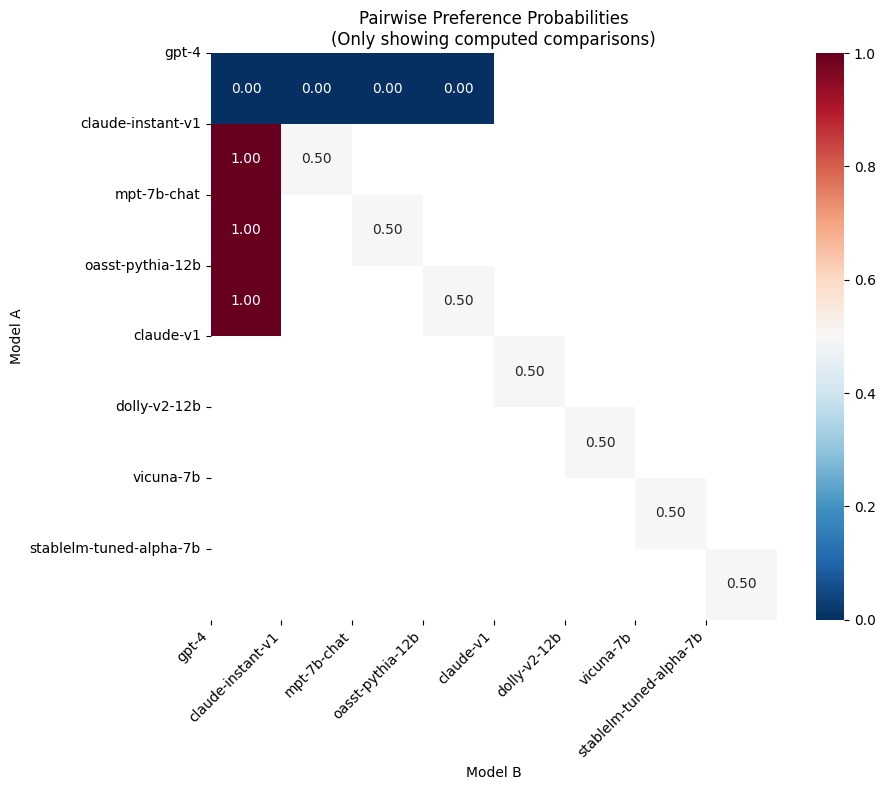

In [11]:
ranking_result = results['ranking_result'].iloc[0]

# Show ranked responses
for rank, response, model in ranking_result.get_ranked_responses():
    print(f"Rank {rank}: {model}")

# Visualize full preference matrix
ranking_result.plot_preference_heatmap()

## Global Scoring and Transitivity in Evaluating LLM Outputs  

### What is Global Scoring?  
Global scoring refers to the process of **ranking multiple responses** to the **same prompt** in a way that ensures a **consistent** and **relative** evaluation across all outputs. Instead of scoring each response in isolation (which can lead to inconsistencies), global scoring ensures that rankings remain **coherent** and **comparable** across different models.

### What is Transitivity?  
**Transitivity** means that if **Response A is preferred over Response B**, and **Response B is preferred over Response C**, then we should also expect **Response A to be preferred over Response C**. This property ensures a **consistent ranking** across all evaluated outputs.

### Example of Transitivity in Pairwise Scoring  
Suppose we evaluate three responses to the same prompt:

- **Response A vs. Response B** → A is preferred (A ≻ B)
- **Response B vs. Response C** → B is preferred (B ≻ C)

If the ranking is **transitive**, then we should also conclude:

- **Response A vs. Response C** → A should be preferred (A ≻ C)

Without transitivity, rankings may become inconsistent, leading to **contradictions** in evaluations. Pairwise preference ranking, combined with a sorting algorithm like **Pairwise Preference Search (PairS)**, ensures that global rankings follow this principle, improving the reliability of model comparisons.

Ranking prompt: How many kg can 1 mm thick par...: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]

Rank 0: gpt-4
Rank 1: claude-instant-v1
Rank 2: mpt-7b-chat
Rank 3: oasst-pythia-12b
Rank 4: claude-v1
Rank 5: dolly-v2-12b
Rank 6: vicuna-7b
Rank 7: stablelm-tuned-alpha-7b


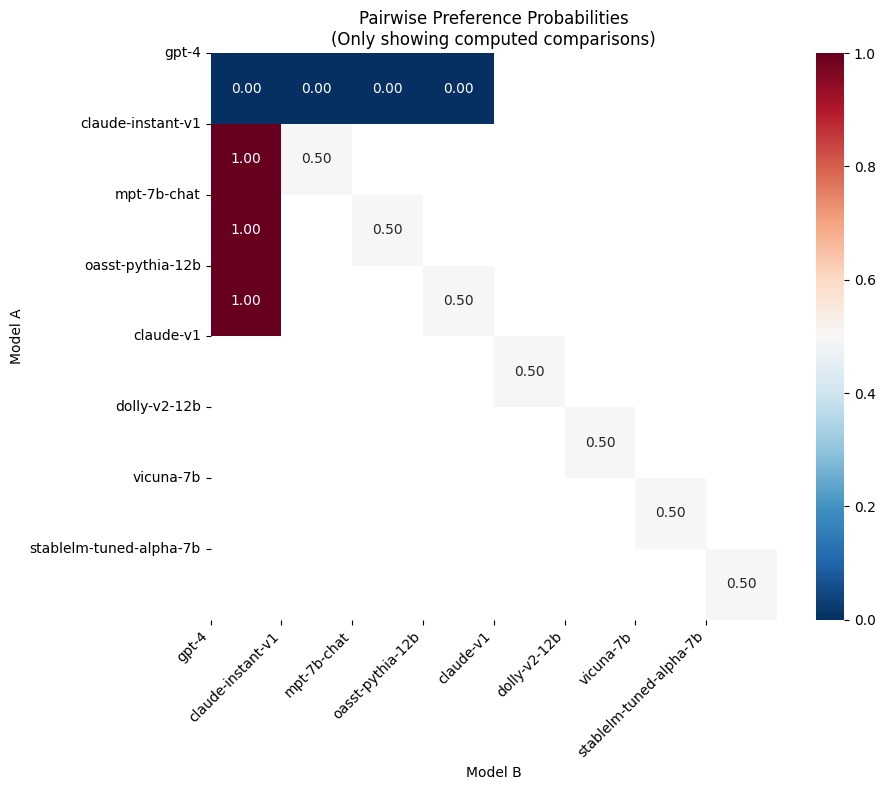

In [12]:
# Rank Responses
ranker = PairwisePreferenceRanker(
    evaluator=evaluator, 
    quality="<helpfulness>",
)

results = ranker.evaluate(
    df=final_df.iloc[[500]],
    prompt_col="prompt",
    responses_col="response",
    model_col="model"
)

ranking_result = results['ranking_result'].iloc[0]

# Show ranked responses
for rank, response, model in ranking_result.get_ranked_responses():
    print(f"Rank {rank}: {model}")

# Visualize full preference matrix
ranking_result.plot_preference_heatmap()


When Do We See a Tie (0.5)?
- The LLM was unsure due to high entropy in its confidence.
- Both responses were of similar quality according to the LLM.
- The responses were dissimilar but equally flawed (e.g., both lacked clarity but had similar coherence).

Since mergesort (or beam search) relies on transitivity to establish a global ranking, this tie does not prevent one model from ultimately ranking higher than the other.

The final ranking will depend on how each model performed against other models in different pairwise comparisons.


This is useful because it means that for some models, differences were clear (values 0 or 1), while others required more comparisons to resolve rankings.

Ranking prompt: Two spheres of the same size a...: 100%|██████████| 1/1 [00:12<00:00, 12.63s/it]

Rank 0: koala-13b
Rank 1: claude-instant-v1
Rank 2: fastchat-t5-3b
Rank 3: llama-13b
Rank 4: gpt-3.5-turbo
Rank 5: chatglm-6b
Rank 6: koala-13b
Rank 7: claude-instant-v1
Rank 8: gpt-3.5-turbo
Rank 9: vicuna-13b


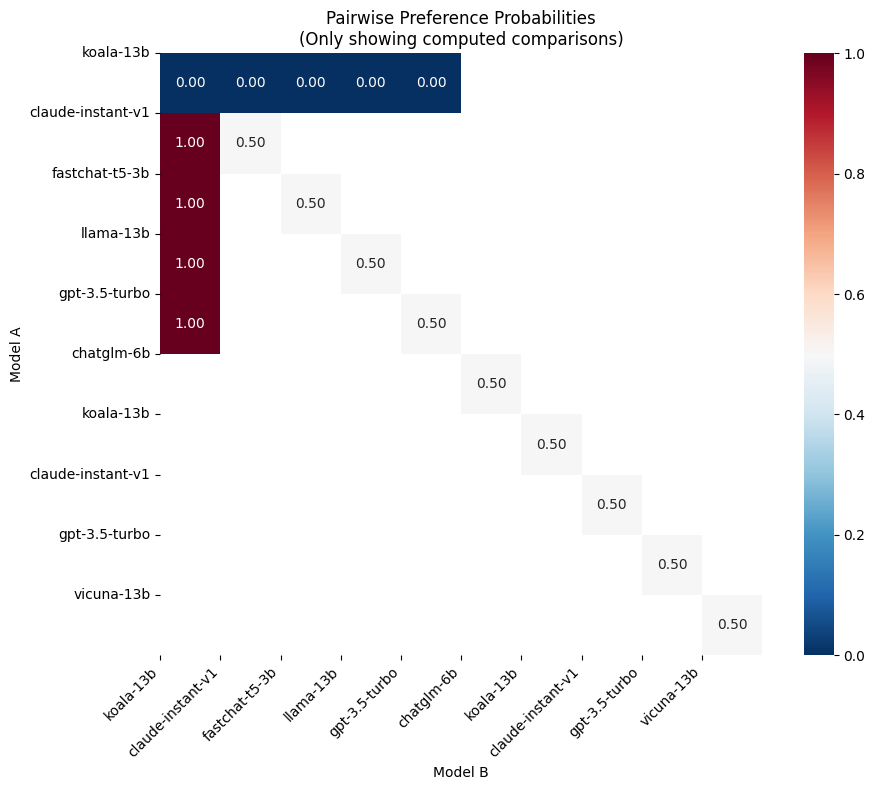

In [14]:
# Rank Responses
ranker = PairwisePreferenceRanker(
    evaluator=evaluator, 
    quality="coherence",
)

results = ranker.evaluate(
    df=final_df.iloc[[300]],
    prompt_col="prompt",
    responses_col="response",
    model_col="model"
)

ranking_result = results['ranking_result'].iloc[0]

# Show ranked responses
for rank, response, model in ranking_result.get_ranked_responses():
    print(f"Rank {rank}: {model}")

# Visualize full preference matrix
ranking_result.plot_preference_heatmap()
